In [1]:
# Import necessary libraries
import cobra
import glob
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import scipy.stats as stats
import seaborn as sns
from cobra.medium import minimal_medium
from itertools import combinations
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

# Set the path for the data
input_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/network_files/'
model_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/'
output_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/5_Model_simulations/'
sample_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/phyloseq_source/'
figure_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Figures/'

In [2]:
# Loading the distances
distance_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/distances/'

# Load the data
function_dist = pd.read_csv(distance_path + '1_functional.tsv', sep = '\t', index_col=0)
mash_dist = pd.read_csv(distance_path + '2_mash.tsv', sep = '\t', index_col=0)
phylo_dist = pd.read_csv(distance_path + '3_phylogenetic.tsv', sep = '\t', index_col=0)

# Display the data
function_dist.head()

,GCF_000019725.1,GCF_000019945.1,GCF_000023145.1,GCF_000023925.1,GCF_000024945.1,GCF_000069945.1,GCF_000083545.1,GCF_000144405.1,GCF_000152185.1,GCF_000153925.1,...,GCF_900099625.1,GCF_900167455.1,GCF_900169275.1,GCF_900176155.1,GCF_900445095.1,GCF_900447555.1,GCF_900453805.1,GCF_900459355.1,GCF_900637975.1,GCF_901542405.1
GCF_000019725.1,0.0000,0.2078,0.6516,0.6056,0.6612,0.6507,0.2194,0.7032,0.5773,0.6998,...,0.6973,0.3717,0.5696,0.6328,0.7003,0.6495,0.5937,0.7247,0.6286,0.5279
GCF_000019945.1,0.2078,0.0000,0.6450,0.6067,0.6615,0.6473,0.1162,0.6929,0.5821,0.6894,...,0.6910,0.3905,0.5857,0.6212,0.6916,0.6455,0.5860,0.7171,0.6279,0.5404
GCF_000023145.1,0.6516,0.6450,0.0000,0.4675,0.5666,0.3217,0.6406,0.6284,0.4338,0.6265,...,0.5512,0.6361,0.4678,0.3419,0.5607,0.3384,0.6090,0.5931,0.4475,0.4524
GCF_000023925.1,0.6056,0.6067,0.4675,0.0000,0.6163,0.4411,0.5949,0.6506,0.3516,0.6404,...,0.6016,0.5952,0.3768,0.4490,0.5970,0.4601,0.6163,0.6227,0.4489,0.4413
GCF_000024945.1,0.6612,0.6615,0.5666,0.6163,0.0000,0.5866,0.6599,0.5947,0.5929,0.5329,...,0.5543,0.6574,0.6162,0.5703,0.5626,0.5671,0.5945,0.5607,0.6021,0.6036


In [3]:
# Community for 8 members
# Load the community data
community_data = pd.read_csv(output_path + 'community_info_2-5-8_10.csv', sep = '\t', header=None)
community_data.columns = ['Community', 'Members']

# Select 8 memebr communities
community_data = community_data[community_data['Community'].str.contains('_8_10')]

community_dict = community_data.groupby('Community')['Members'].apply(list).to_dict()
community_dict

{'Hospital_8_10_1': ['Staphylococcus_aureus',
  'Corynebacterium_kroppenstedtii',
  'Klebsiella_pneumoniae',
  'Gardnerella_vaginalis',
  'Veillonella_parvula',
  'Mediterraneibacter_gnavus',
  'Rothia_mucilaginosa',
  'Streptococcus_parasanguinis'],
 'Hospital_8_10_10': ['Micrococcus_luteus',
  'Staphylococcus_aureus',
  'Scardovia_wiggsiae',
  'Prevotella_histicola',
  'Enterococcus_faecium',
  'Corynebacterium_tuberculostearicum',
  'Acinetobacter_baumannii',
  'Cutibacterium_acnes'],
 'Hospital_8_10_2': ['Rothia_dentocariosa',
  'Streptococcus_sanguinis',
  'Haemophilus_parainfluenzae',
  'Rothia_aeria',
  'Corynebacterium_kroppenstedtii',
  'Enterococcus_faecium',
  'Acinetobacter_baumannii',
  'Corynebacterium_accolens'],
 'Hospital_8_10_3': ['Staphylococcus_aureus',
  'Xanthomonas_citri',
  'Enterobacter_cloacae',
  'Enhydrobacter_aerosaccus',
  'Veillonella_atypica',
  'Prevotella_histicola',
  'Staphylococcus_epidermidis',
  'Streptococcus_parasanguinis'],
 'Hospital_8_10_4': 

In [4]:
# Loading the metadata
metadata_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/'
metadata = pd.read_csv(metadata_path + 'accession_details.csv', sep = ',', index_col=0)

metadata.index = metadata.index.str.replace(' ', '_')
metadata.index = metadata.index.str.replace('Kocuria_sp._UCD-OTCP', 'Kocuria_sp.')
metadata.index = metadata.index.str.replace('Roseomonas_sp._B5', 'Roseomonas_sp.')
metadata.index = metadata.index.str.replace('Dermacoccus_sp._Ellin185', 'Dermacoccus_sp.')

metadata

,assembly_accession
organism_name,
Abiotrophia_defectiva,GCF_037041345.1
Achromobacter_xylosoxidans,GCF_022870085.1
Acinetobacter_baumannii,GCF_000369385.1
Acinetobacter_johnsonii,GCF_016027055.1
Acinetobacter_junii,GCF_000430225.1
...,...
Stutzerimonas_stutzeri,GCF_000219605.1
Veillonella_atypica,GCF_002959915.1
Veillonella_parvula,GCF_000024945.1


In [5]:
# Check if all the members are present in the metadata
set(metadata['assembly_accession']) - set(function_dist.index)

set()

In [6]:
def mean_dist(community_dict, metadata, dist):
        
    # Calculate the mean distance for each community
    mean_dist = {}
    for community in community_dict.keys():
        members = community_dict[community]
        accessions = metadata.loc[members, 'assembly_accession'].tolist()
        median_distance = dist.loc[accessions, accessions]
        upper_triangle = median_distance.where(np.triu(np.ones(median_distance.shape), k=1).astype(bool))
        upper_triangle_values = upper_triangle.stack().values.tolist()
        mean_dist[community] = np.mean(upper_triangle_values)
    return mean_dist

def calculate_mean_all_dist(community_dict, metadata, function_dist, mash_dist, phylo_dist):
    
    # functional distance
    function_mean = mean_dist(community_dict, metadata, function_dist)
    mash_mean = mean_dist(community_dict, metadata, mash_dist)
    phylo_mean = mean_dist(community_dict, metadata, phylo_dist)


    # Create a dataframe
    median_df = pd.DataFrame([function_mean, mash_mean, phylo_mean]).T
    median_df.columns = ['Functional', 'Mash', 'Phylogenetic']
    return median_df

mean_df = calculate_mean_all_dist(community_dict, metadata, function_dist, mash_dist, phylo_dist)
mean_df

,Functional,Mash,Phylogenetic
Hospital_8_10_1,0.599407,0.847964,1.382025
Hospital_8_10_10,0.583132,0.874286,1.423061
Hospital_8_10_2,0.550446,0.943632,1.352725
Hospital_8_10_3,0.601118,0.721075,1.383568
Hospital_8_10_4,0.598754,0.871929,1.374214
Hospital_8_10_5,0.587357,0.974857,1.292939
Hospital_8_10_6,0.576868,0.899429,1.387000
Hospital_8_10_7,0.517550,0.719086,1.184243
Hospital_8_10_8,0.564764,0.843621,1.320618
Hospital_8_10_9,0.592150,0.921271,1.295132


<Figure size 1000x600 with 0 Axes>

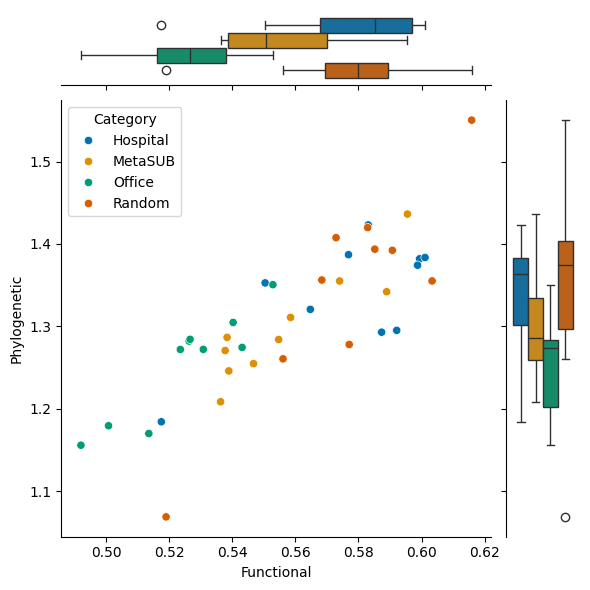

In [7]:
# Create a new column for color categorization based on index
mean_df['Category'] = mean_df.index.str.split('_').str[0]

# Plot
plt.figure(figsize=(10, 6))
g = sns.JointGrid(data=mean_df, x='Functional', y='Phylogenetic', hue='Category', palette='colorblind')
g.plot(sns.scatterplot, sns.boxplot)

# Add labels and title
plt.xlabel('Functional')
plt.ylabel('Phylogenetic')

# Show plot
plt.show()

Text(463.154761904762, 0.5, 'Mash')

<Figure size 1000x600 with 0 Axes>

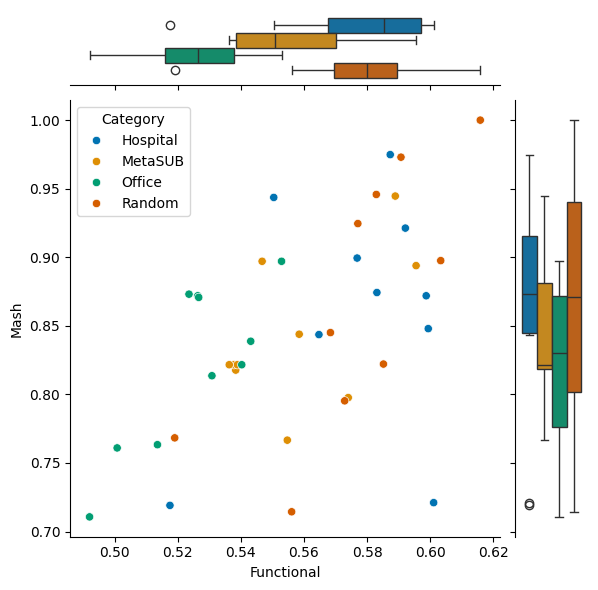

In [8]:
# Plot
plt.figure(figsize=(10, 6))
g = sns.JointGrid(data=mean_df, x='Functional', y='Mash', hue='Category', palette='colorblind')
g.plot(sns.scatterplot, sns.boxplot)

# Add labels and title
plt.xlabel('Functional')
plt.ylabel('Mash')

In [9]:
# Detailed smetana
community_data

# Detailed smetana path
ds_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/'

# Save the community details
community_data.to_csv(ds_path + 'community_info_8_10.csv', sep = '\t', index=False, header=False)

In [24]:
# Creating smetana file
# Global
# Bash script to run smetana
with open(ds_path + '8_10_global_complete_run_smetana.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/community_info_8_10.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/outcom_global_complete_8_10.csv \\\n")
    f.write("    --solver cplex --flavor bigg --molweight")

# Run the bash script
!chmod +x {ds_path + '8_10_global_complete_run_smetana.sh'}
!bash {ds_path + '8_10_global_complete_run_smetana.sh'}

<Figure size 1000x600 with 0 Axes>

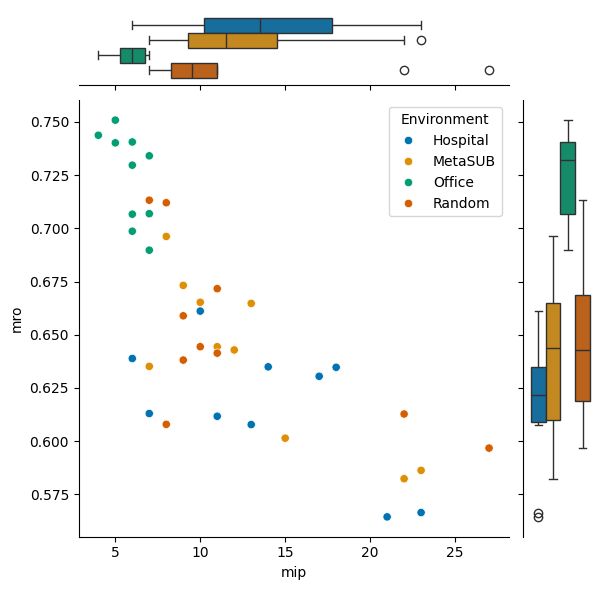

In [15]:
# Display the output
outcom_global_complete = pd.read_csv(ds_path + 'outcom_global_complete_8_10.csv_global.tsv', sep = '\t')
outcom_global_complete = outcom_global_complete.dropna()

outcom_global_complete[['Environment', 'Community Size', 'Iterations',
                        'Community Number']] = outcom_global_complete['community'].str.split('_', expand = True)

outcom_global_complete.head()

# Plot the results
plt.figure(figsize=(10, 6))
g = sns.JointGrid(data=outcom_global_complete, x='mip', y='mro', hue='Environment', palette='colorblind')
g.plot(sns.scatterplot, sns.boxplot)

In [11]:
# Loading pathogen data
pathogen_data = pd.read_csv('/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/' + 'taxa_binary_pathogen.tsv', sep = '\t', index_col=0)

# Idenitfy the pathogens present in the hospital microbiome
hosp_pathogen = pathogen_data[(pathogen_data['Hospital'] == 1) & 
                                (pathogen_data['MetaSUB'] == 0) &
                                (pathogen_data['Office'] == 0) &
                                (pathogen_data['Present'] == 'Yes')]

hosp_pathogen.index = hosp_pathogen.index.str.replace(' ', '_')
hosp_pathogen

,Hospital,MetaSUB,Office,Present,Biosafety level
Organisms,,,,,
Acinetobacter_baumannii,1,0,0,Yes,BSL-2
Acinetobacter_ursingii,1,0,0,Yes,BSL-2
Corynebacterium_propinquum,1,0,0,Yes,BSL-2
Corynebacterium_striatum,1,0,0,Yes,BSL-2
Enterococcus_faecalis,1,0,0,Yes,BSL-2
Enterococcus_faecium,1,0,0,Yes,BSL-2
Phocaeicola_dorei,1,0,0,Yes,BSL-1
Prevotella_bivia,1,0,0,Yes,BSL-2
Prevotella_histicola,1,0,0,Yes,BSL-2


In [12]:
random.seed(42)

# Select the members to perturb
pert_members = hosp_pathogen.index.tolist()

# Function to perturb the community
def community_perturbation(community_data, community_dict, pert_members, pert_count=1):
    
    # Copy the community data
    community_data_updated = community_data.copy()

    # Adding members to the community
    for community in community_data.Community.unique():
        selected_members = random.sample(pert_members, pert_count)
        members = community_dict[community]
        for member in selected_members:
            if member not in members:
                community_data_updated = community_data_updated._append({'Community': community,
                                                                       'Members': member}, ignore_index=True)

    return community_data_updated

# Perturb the community
for i in range(1,4):
    updated_community_data = community_perturbation(community_data, community_dict, pert_members, i)
    updated_community_data.to_csv(ds_path + 'community_info_8_10_perturbation_' + str(i) + '.csv', sep = '\t', index=False, header=False)

# Creating smetana file
# Global
# Bash script to run smetana
for i in range(1,4):
    with open(ds_path + '8_10_global_complete_perturbation_' + str(i) + '_run_smetana.sh', 'w') as f:
        f.write("#!/bin/bash\n")
        f.write("smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
        f.write("    -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/community_info_8_10_perturbation_" + str(i) + ".csv \\\n")
        f.write("    -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/outcom_global_complete_perturbation_" + str(i) + ".csv \\\n")
        f.write("    --solver cplex --flavor bigg --molweight")

    # Run the bash script
    !chmod +x {ds_path + '8_10_global_complete_perturbation_' + str(i) + '_run_smetana.sh'}
    !bash {ds_path + '8_10_global_complete_perturbation_' + str(i) + '_run_smetana.sh'}


In [16]:
# Compare the results
perturbation_results = {}
perturbation_results['Original'] = outcom_global_complete
for i in range(1,4):
    outcom_global_complete_pert = pd.read_csv(ds_path + 'outcom_global_complete_perturbation_' + str(i) + '.csv_global.tsv', sep = '\t')
    outcom_global_complete_pert = outcom_global_complete_pert.dropna()
    outcom_global_complete_pert[['Environment', 'Community Size', 'Iterations',
                            'Community Number']] = outcom_global_complete_pert['community'].str.split('_', expand = True)
    perturbation_results['Pert_'+str(i)] = outcom_global_complete_pert

perturbation_results

{'Original':            community    medium  size  mip       mro Environment  \
 0    Hospital_8_10_1  complete     8   21  0.564417    Hospital   
 1   Hospital_8_10_10  complete     8   13  0.607792    Hospital   
 2    Hospital_8_10_2  complete     8    7  0.612987    Hospital   
 3    Hospital_8_10_3  complete     8   10  0.661105    Hospital   
 4    Hospital_8_10_4  complete     8   18  0.634708    Hospital   
 5    Hospital_8_10_5  complete     8   17  0.630476    Hospital   
 6    Hospital_8_10_6  complete     8   14  0.634921    Hospital   
 7    Hospital_8_10_7  complete     8    6  0.638844    Hospital   
 8    Hospital_8_10_8  complete     8   11  0.611697    Hospital   
 9    Hospital_8_10_9  complete     8   23  0.566445    Hospital   
 10    MetaSUB_8_10_1  complete     8   13  0.664723     MetaSUB   
 11   MetaSUB_8_10_10  complete     8   11  0.644377     MetaSUB   
 12    MetaSUB_8_10_2  complete     8    9  0.673190     MetaSUB   
 13    MetaSUB_8_10_3  complete     

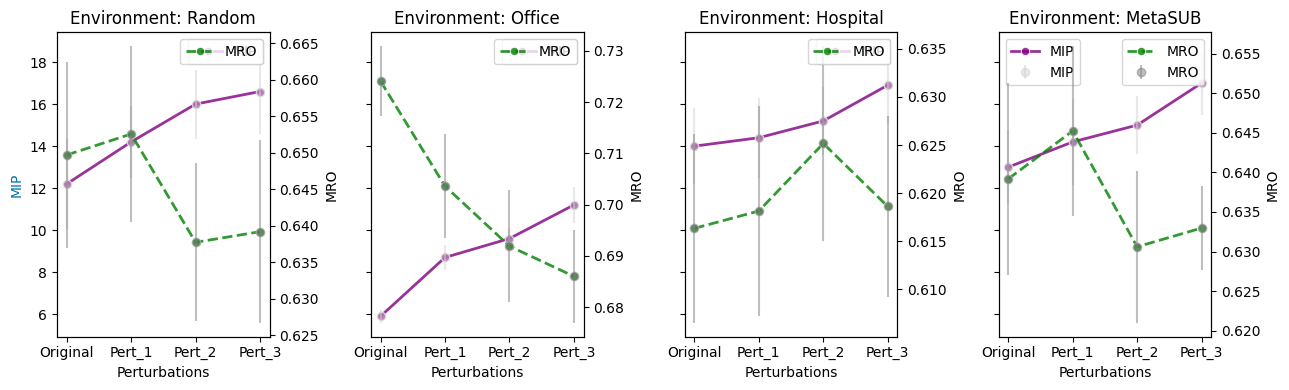

In [49]:
# Calculate the error values
def calculate_error_values(env, data_dict):
    # Extract the data for each perturbation for the environment
    env_data = {key: df[df['Environment'] == env] for key, df in data_dict.items()}

    # Calculate mean and standard deviation for MIP and MRO across perturbations
    mip_means = [env_data[key]['mip'].mean() for key in data_dict.keys()]
    mip_sems = [env_data[key]['mip'].sem() for key in data_dict.keys()]
    
    mro_means = [env_data[key]['mro'].mean() for key in data_dict.keys()]
    mro_sems = [env_data[key]['mro'].sem() for key in data_dict.keys()]

    return mip_means, mip_sems, mro_means, mro_sems

# Plot the results in subplots
def plot_environment_data_with_errors(envs, data_dict):
    # Create a subplot with a column for each environment
    fig, axes = plt.subplots(1, len(envs), figsize=(13, 4), sharex=True, sharey=True)
    
    # Line style options
    mip_styles = ['-', '--']  # solid for MIP, dashed for MRO
    
    # Color options
    colors = sns.color_palette('colorblind')  # generate vibrant colors
    
    for i, env in enumerate(envs):
        mip_means, mip_sems, mro_means, mro_sems = calculate_error_values(env, data_dict)
        
        # X-axis labels for different perturbations
        x_labels = list(data_dict.keys())

        # Plot MIP on the primary y-axis with error bars (left axis)
        ax1 = axes[i]
        sns.lineplot(x=x_labels, y=mip_means, ax=ax1, color='purple', marker='o', label='MIP', 
                     err_style='bars', err_kws={'elinewidth': 2}, lw=2, linestyle=mip_styles[0], alpha=0.8)
        ax1.errorbar(x_labels, mip_means, yerr=mip_sems, fmt='o', color='lightgrey', label='MIP', alpha = 0.5)
        ax1.set_ylabel('MIP', color=colors[i])
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.set_title(f'Environment: {env}')
        
        # Create a secondary y-axis for MRO with error bars (right axis)
        ax2 = ax1.twinx()
        sns.lineplot(x=x_labels, y=mro_means, ax=ax2, color='green', marker='o', label='MRO', 
                     err_style='bars', err_kws={'elinewidth': 2}, lw=2, linestyle=mip_styles[1], alpha=0.8)
        ax2.errorbar(x_labels, mro_means, yerr=mro_sems, fmt='o', color='grey', label='MRO', alpha = 0.5)
        ax2.set_ylabel('MRO', color='black')
        ax2.tick_params(axis='y', labelcolor='black')

        # Set x-axis label for all plots
        ax1.set_xlabel('Perturbations')

    # Legend
    ax1.legend(loc='upper left',)
    ax2.legend(loc='upper right')

    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Get the environments excluding 'Hospital'
environments = list(set(perturbation_results['Original']['Environment'].unique())) #- {'Hospital'})

# Plot the results in subplots
plot_environment_data_with_errors(environments, perturbation_results)


In [41]:
community_data

,Community,Members
70,Hospital_8_10_1,Staphylococcus_aureus
71,Hospital_8_10_1,Corynebacterium_kroppenstedtii
72,Hospital_8_10_1,Klebsiella_pneumoniae
73,Hospital_8_10_1,Gardnerella_vaginalis
74,Hospital_8_10_1,Veillonella_parvula
...,...,...
595,Random_8_10_10,Massilia_timonae
596,Random_8_10_10,Mycolicibacterium_fortuitum
597,Random_8_10_10,Klebsiella_pneumoniae
598,Random_8_10_10,Enterobacter_cloacae


In [43]:
for community in community_data['Community'].unique():
    community_data[community_data['Community'] == community].to_csv(ds_path + community + '.csv', sep = '\t', index=False, header=False)

    # Bash script to run smetana
    with open(ds_path + community + '_detailed_complete_run_smetana.sh', 'w') as f:
        f.write("#!/bin/bash\n")
        f.write("smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
        f.write("    -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/" + community + ".csv \\\n")
        f.write("    -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/outcom_detailed_complete_" + community + ".csv \\\n")
        f.write("    --solver cplex --flavor bigg --molweight --detailed")
    
    # Print the status
    print('Running Smetana for community:', community)

    # Run the bash script
    !chmod +x {ds_path + community + 'detailed_complete_run_smetana.sh'}
    !bash {ds_path + community + 'detailed_complete_run_smetana.sh'}

    # Remove the bash script
    !rm {ds_path + community + 'detailed_complete_run_smetana.sh'}
    !rm {ds_path + community + '.csv'}


Running Smetana for community: Hospital_8_10_1
Running Smetana for community: Hospital_8_10_2
Running Smetana for community: Hospital_8_10_3
Running Smetana for community: Hospital_8_10_4
Running Smetana for community: Hospital_8_10_5
Running Smetana for community: Hospital_8_10_6
Running Smetana for community: Hospital_8_10_7
Running Smetana for community: Hospital_8_10_8
Running Smetana for community: Hospital_8_10_9
Running Smetana for community: Hospital_8_10_10
Running Smetana for community: MetaSUB_8_10_1
Running Smetana for community: MetaSUB_8_10_2
Running Smetana for community: MetaSUB_8_10_3
Running Smetana for community: MetaSUB_8_10_4
Running Smetana for community: MetaSUB_8_10_5
Running Smetana for community: MetaSUB_8_10_6
Running Smetana for community: MetaSUB_8_10_7
Running Smetana for community: MetaSUB_8_10_8
/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/MetaSUB_8_10_8detailed_complete_run_smetana.sh: line 5: 2004395 S

AttributeError: 'DataFrame' object has no attribute 'append'

In [49]:
# Compile the results
detailed_smetana = pd.DataFrame()
for community in community_data['Community'].unique():
    if os.path.exists(ds_path + 'outcom_detailed_complete' + community + '.csv_detailed.tsv'):
        detailed_smetana = pd.concat([detailed_smetana, pd.read_csv(ds_path + 'outcom_detailed_complete' + community + '.csv_detailed.tsv', sep = '\t')])

    # Print the status
    print('Finished compiling for community:', community)

    # Remove the file
    !rm {ds_path + 'outcom_detailed_complete' + community + '.csv_detailed.tsv'}

Finished compiling for community: Hospital_8_10_1
rm: cannot remove '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/outcom_detailed_completeHospital_8_10_1.csv_detailed.tsv': No such file or directory
Finished compiling for community: Hospital_8_10_2
rm: cannot remove '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/outcom_detailed_completeHospital_8_10_2.csv_detailed.tsv': No such file or directory
Finished compiling for community: Hospital_8_10_3
rm: cannot remove '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/outcom_detailed_completeHospital_8_10_3.csv_detailed.tsv': No such file or directory
Finished compiling for community: Hospital_8_10_4
rm: cannot remove '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/outcom_detailed_completeHospital_8_10_4.csv_detailed.tsv': No such file or directory


In [51]:
detailed_smetana.to_csv(ds_path + 'detailed_smetana_8_10_secondary.csv', sep = '\t', index=False)

In [48]:
detailed_smetana.to_csv(ds_path + 'detailed_smetana_8_10_primary.csv', sep = '\t', index=False)

In [55]:
community_data

,Community,Members
70,Hospital_8_10_1,Staphylococcus_aureus
71,Hospital_8_10_1,Corynebacterium_kroppenstedtii
72,Hospital_8_10_1,Klebsiella_pneumoniae
73,Hospital_8_10_1,Gardnerella_vaginalis
74,Hospital_8_10_1,Veillonella_parvula
...,...,...
595,Random_8_10_10,Massilia_timonae
596,Random_8_10_10,Mycolicibacterium_fortuitum
597,Random_8_10_10,Klebsiella_pneumoniae
598,Random_8_10_10,Enterobacter_cloacae


In [63]:
pert_members = ["Staphylococcus_aureus", "Rothia_dentocariosa"]

updated_community_data = community_data.copy()

for community in community_data.Community.unique():
    members = community_dict[community]
    for member in pert_members:
        if member not in members:
            updated_community_data = updated_community_data._append({'Community': community,
                                                                    'Members': member}, ignore_index=True)

updated_community_data

updated_community_data.to_csv(ds_path + 'community_info_8_10_pert.csv', sep = '\t', index=False, header=False)

In [64]:
# Creating smetana file
# Detailed
# Bash script to run smetana
with open(ds_path + '8_10_global_complete_pert_run_smetana.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/community_info_8_10_pert.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/outcom_global_complete_perb_8_10.csv \\\n")
    #f.write("    -p /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Detailed_smetana_8_members/perturb.txt \\\n")
    f.write("    --solver cplex --flavor bigg --molweight")

# Run the bash script
!chmod +x {ds_path + '8_10_global_complete_pert_run_smetana.sh'}
!bash {ds_path + '8_10_global_complete_pert_run_smetana.sh'}